In [2]:
import os
import time as t
import re
import numpy as np
import math
from os import listdir
from os.path import isfile, join

from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as patches
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.gridspec as gridspec

from scipy.ndimage import imread
from scipy import ndimage
from scipy.ndimage.filters import gaussian_filter

from PIL import Image

from utils import *

In [4]:
path_input = u'e:\\Data\\burst\\'
path_output = u'e:\\Data\\burst\\test\\'

raws = read_tiff(path_input + 'raws_16_45_00.tif', 100)
flats= read_tiff(path_input + 'flats_16_45_31.tif', 100)

In [17]:
# remove frames, startng form 1 as a first index value
index_remove_raw = np.array([2,9,10,17,18,25,32,33,40,41,48,49,56,64,71,72,79,
                             80,87,88,95,102,103,110,111,114,115]) - 1 
rest_frames = np.arange(116, 128)
remove_indexes = np.concatenate((index_remove_raw, rest_frames))
raws = np.delete(raws, remove_indexes)



In [5]:
i = 0

im = raws[0]
flat = flats[0]

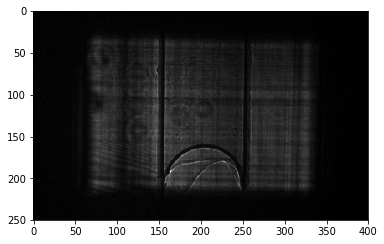

In [6]:
plt.imshow(im, cmap='gray')

## Make Flats

In [13]:
flats_high_pass = []

sigma = 2.0

for f in flats:
    flats_high_pass.append( f / gaussian_filter(f, sigma=sigma))
  
mean_flat = np.mean(flats_high_pass, axis=0)

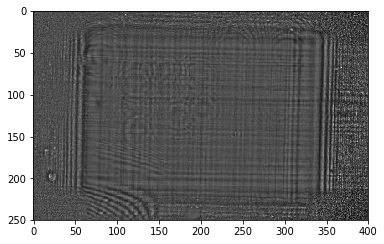

In [14]:
plt.imshow(mean_flat, cmap='gray')

In [15]:
a = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])
index = [2, 3, 6]

new_a = np.delete(a, index)

print(new_a)

[1 2 5 6 8 9]
